In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import os
import json
import re
import random
import csv
from tqdm.auto import tqdm
# install bitsandbytes and restart

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def load_json_from_drive(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

tomi = load_json_from_drive("/content/drive/MyDrive/SEF/Data/ToMi/tomi_all.json")
bigtom = load_json_from_drive("/content/drive/MyDrive/SEF/Data/BigToM/bigtom_all.json")

In [4]:
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding=True, truncation=True, model_max_length=512)
tokenizer.padding_side = "left"
tokenizer.truncation_side = "right"

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16,
)
model.eval()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

# Intervention with Forward Hooks

In [5]:
import numpy as np
tomi_weights = np.load('/content/drive/MyDrive/SEF/Data/Tensors/phase_1_tomi_contrastive_weights.npy')

# Primary Metric

In [6]:
import re
from collections import defaultdict

# prompt formatting
def build_tomi_prompt(story, question, *, force_short_answer=True):
  if force_short_answer:
    return (
        f'Only respond with the answer from the following text. Text: "The traveler moved from the outskirts of London into the city center. Where is the traveller?" Answer: London\nText: "After years in Tokyo, he decided to move to the countryside. Where did he originally live?" Answer: Tokyo\nText: "{story} {question}" Answer:'
    )
  else:
    return f"{story}\n{question}"

def extract_location(text):
    text = text.strip()
    toks = re.findall(r"[A-Za-z_]+", text)
    return toks[0].lower() if toks else ""

def generate_location_answer(
    model,
    tokenizer,
    prompt,
    *,
    max_new_tokens=8,
    model_max_length=512,
 ):
  inputs = tokenizer(prompt, return_tensors="pt",
                     truncation=True,
                     max_length=model_max_length,
                     padding=False,).to(model.device)
  with torch.no_grad():
    out_ids = model.generate(
        **inputs, do_sample=False, temperature=1.0,
        max_new_tokens=max_new_tokens, num_beams=1,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
  decoded = tokenizer.decode(out_ids[0], skip_special_tokens=True)

  prefix = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)
  if decoded.startswith(prefix):
    gen_part = decoded[len(prefix):].strip()
  else:
    gen_part = decoded.strip()

  loc = extract_location(gen_part)
  return gen_part, loc



In [7]:
import string
from typing import List

# -------------------------
# Token index selection (question end)
# -------------------------
def _question_end_char(prompt: str) -> int:
    if "Answer:" in prompt:
        prompt = prompt.split("Answer:")[0]
    q_idx = prompt.rfind("?")
    if q_idx != -1:
        return q_idx + 1
    prompt = prompt.rstrip()
    while len(prompt) > 0 and prompt[-1] in string.punctuation + " ":
        prompt = prompt[:-1].rstrip()
    return len(prompt)

def _select_token_index(offsets, attention_mask, end_char: int) -> int:
    idx = None
    for i, (start, end) in enumerate(offsets):
        if attention_mask[i] == 0:
            continue
        if end == 0:
            continue
        if end <= end_char:
            idx = i
    if idx is not None:
        return idx
    non_pad = [i for i, m in enumerate(attention_mask) if m == 1]
    return non_pad[-1] if non_pad else 0

def select_question_token_indices(
    tokenizer, prompts: List[str], *, max_length: int = 512
 ) -> List[int]:
    end_chars = [_question_end_char(p) for p in prompts]
    encoded = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
        return_offsets_mapping=True,
    )
    offsets = encoded.pop("offset_mapping").tolist()
    attention_mask = encoded["attention_mask"].tolist()
    return [
        _select_token_index(offsets[i], attention_mask[i], end_chars[i])
        for i in range(len(prompts))
    ]

# -------------------------
# Activation extraction & contrastive vector
# -------------------------
def extract_block_outputs_at_indices(
    model, tokenizer, prompts: List[str], layer_idx: int, token_indices: List[int], *,
    batch_size: int = 8, max_length: int = 512,
 ) -> torch.Tensor:
    activations = []
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i+batch_size]
        batch_indices = token_indices[i:i+batch_size]
        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
        )
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        captured = {}
        def _hook_fn(module, ins, outs):
            out = outs[0] if isinstance(outs, tuple) else outs
            captured["hidden"] = out
            return outs
        handle = model.model.layers[layer_idx].register_forward_hook(_hook_fn)
        with torch.no_grad():
            _ = model(**inputs)
        handle.remove()
        hidden = captured["hidden"]
        idx_t = torch.tensor(batch_indices, device=hidden.device)
        idx_t = torch.clamp(idx_t, 0, hidden.size(1) - 1)
        batch_act = hidden[torch.arange(hidden.size(0), device=hidden.device), idx_t]
        activations.append(batch_act.detach().cpu())
    return torch.cat(activations, dim=0)

def build_contrastive_vector(activations: torch.Tensor, labels: List[int]) -> torch.Tensor:
    y = torch.tensor(labels, dtype=torch.int64)
    true_mask = y == 1
    false_mask = y == 0
    true_mean = activations[true_mask].mean(dim=0)
    false_mean = activations[false_mask].mean(dim=0)
    return true_mean - false_mean

# -------------------------
# Intervention hook (residual block output)
# -------------------------
class ResidualIntervention:
    def __init__(self, model, layer_idx: int, direction, alpha: float, token_indices: List[int]):
        self.model = model
        self.layer_idx = int(layer_idx)
        self.alpha = float(alpha)
        self.handle = None
        if not torch.is_tensor(direction):
            direction = torch.tensor(direction, dtype=torch.float16)
        self.direction = direction
        self.token_indices = token_indices
        try:
            model_hidden = model.config.hidden_size
            if self.direction.numel() != model_hidden:
                raise ValueError(
                    f"direction dim {self.direction.numel()} != model hidden_size {model_hidden}"
                )
        except Exception:
            pass

    def _hook_fn(self, module, inputs, output):
        if not torch.is_tensor(output):
            return output
        if isinstance(output, tuple):
            out = output[0]
            rest = output[1:]
        else:
            out = output
            rest = None

        out = out.clone()
        bsz = out.size(0)
        idx = torch.tensor(self.token_indices[:bsz], device=out.device)
        idx = torch.clamp(idx, 0, out.size(1) - 1)
        delta = (self.alpha * self.direction).to(device=out.device, dtype=out.dtype)
        out[torch.arange(bsz, device=out.device), idx, :] = (
            out[torch.arange(bsz, device=out.device), idx, :] + delta
        )
        if rest is None:
            return out
        return (out, *rest)

    def __enter__(self):
        block = self.model.model.layers[self.layer_idx]
        self.handle = block.register_forward_hook(self._hook_fn)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self.handle is not None:
            self.handle.remove()
            self.handle = None

# -------------------------
# Evaluation
# -------------------------
def evaluate_intervention_accuracy(
    model, tokenizer, examples, tomi_weights, *, layer_idx=17,
    alphas=(-5,-2,-0,2,5), max_new_tokens=8, model_max_length=512,
    force_short_answer=True,
 ):
    results = {alpha: {"correct": 0, "total": 0, "samples": []} for alpha in alphas}
    w = torch.tensor(tomi_weights, dtype=torch.float16)
    w = w / (w.norm() + 1e-8)

    for ex_i, ex in enumerate(examples):
        story_lines = ex["story"]
        question = ex["question"]
        gold = ex['answer'].strip().lower()
        prompt = build_tomi_prompt(story_lines, question,
                                   force_short_answer=force_short_answer)
        token_idx = select_question_token_indices(
            tokenizer, [prompt], max_length=model_max_length
        )[0]
        for alpha in alphas:
            if alpha == 0:
                gen_text, pred = generate_location_answer(
                    model, tokenizer, prompt,
                    max_new_tokens=max_new_tokens, model_max_length=model_max_length,
                )
            else:
                with ResidualIntervention(
                    model, layer_idx=layer_idx, direction=w, alpha=float(alpha),
                    token_indices=[token_idx],
                ):
                    gen_text, pred = generate_location_answer(
                        model, tokenizer, prompt,
                        max_new_tokens=max_new_tokens,
                        model_max_length=model_max_length,
                    )
            is_correct = (pred == gold)
            results[alpha]["correct"] += int(is_correct)
            results[alpha]["total"] += 1
            if ex_i < 10:
                results[alpha]['samples'].append({
                    "gold": gold,
                    "pred": pred,
                    "gen": gen_text,
                    "question": question,
                })
    acc = {alpha: (results[alpha]['correct'] / max(1, results[alpha]['total']))
           for alpha in alphas}
    return acc, results

def print_accuracy_table(acc):
    print("\nAccuracy vs intervention strength a")
    print("--------------------------------")
    for a in sorted(acc.keys()):
        print(f"a = {a:>4}: accuracy = {acc[a]}")

In [9]:
alphas = (-4, -3, -2, 0, 2, 3, 4)

acc, raw = evaluate_intervention_accuracy(
    model=model, tokenizer=tokenizer,
    examples=tomi[:100],
    tomi_weights=tomi_weights, layer_idx=17, alphas = alphas,
    max_new_tokens=8, model_max_length=512,
    force_short_answer=True,
)

print_accuracy_table(acc)


Accuracy vs intervention strength a
--------------------------------
a =   -4: accuracy = 0.8
a =   -3: accuracy = 0.8
a =   -2: accuracy = 0.8
a =    0: accuracy = 0.8
a =    2: accuracy = 0.8
a =    3: accuracy = 0.79
a =    4: accuracy = 0.8


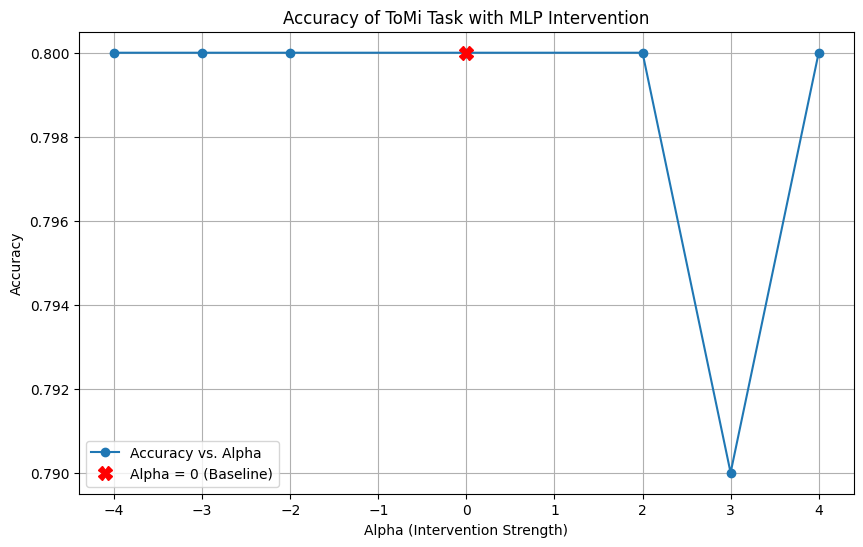

In [10]:
import matplotlib.pyplot as plt

# Combine all accuracy results into a single dictionary
all_accuracies = {}
all_accuracies.update(acc)

# Sort the alphas and their corresponding accuracies
sorted_alphas = sorted(all_accuracies.keys())
sorted_accuracies = [all_accuracies[alpha] for alpha in sorted_alphas]

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_alphas, sorted_accuracies, marker='o', linestyle='-', label='Accuracy vs. Alpha')

# Add a marker at alpha = 0
if 0 in all_accuracies:
    plt.plot(0, all_accuracies[0], 'X', markersize=10, color='red', label='Alpha = 0 (Baseline)')

# Add labels and title
plt.xlabel('Alpha (Intervention Strength)')
plt.ylabel('Accuracy')
plt.title('Accuracy of ToMi Task with MLP Intervention')
plt.grid(True)
plt.legend()
plt.show()

# Control

In [ ]:
# Energy-matched, layer- and direction-specific intervention sweep
import math
import random
from typing import Dict, List, Tuple

def normalize_direction(w):
    if torch.is_tensor(w):
        v = w.float().detach().cpu()
    else:
        v = torch.tensor(w, dtype=torch.float32)
    v = v / (v.norm() + 1e-8)
    return v

def sample_random_unit_vectors(dim: int, n: int = 3, seed: int = 0):
    g = torch.Generator(device="cpu")
    g.manual_seed(seed)
    vecs = torch.randn((n, dim), generator=g)
    vecs = vecs / (vecs.norm(dim=1, keepdim=True) + 1e-8)
    return vecs

In [ ]:
import math
import random
from typing import Dict, List, Tuple, Optional
from matplotlib import pyplot as plt

def build_tomi_prompts(examples, *, force_short_answer: bool = True):
    return [
        build_tomi_prompt(ex["story"], ex["question"], force_short_answer=force_short_answer)
        for ex in examples
    ]

def tokenize_prompts(
    tokenizer,
    prompts: List[str],
    *,
    model_max_length: int = 512,
    device: Optional[torch.device] = None,
 ):
    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        truncation=True,
        max_length=model_max_length,
        padding=True,
    )
    if device is None:
        device = torch.device("cpu")
    return {k: v.to(device) for k, v in inputs.items()}

class MLPInterventionEnergyMatched:
    def __init__(self, model, layer_idx: int, direction, alpha: float, rms_scale: float, token_pos=None):
        self.model = model
        self.layer_idx = int(layer_idx)
        self.alpha = float(alpha)
        self.rms_scale = float(rms_scale)
        self.token_pos = token_pos
        self.handle = None

        if not torch.is_tensor(direction):
            direction = torch.tensor(direction)
        param = next(model.parameters())
        self.direction = direction.to(device=param.device, dtype=param.dtype)

        # sanity check on hidden size
        try:
            model_hidden = model.config.hidden_size
            if self.direction.numel() != model_hidden:
                raise ValueError(
                    f"direction dim {self.direction.numel()} != model hidden_size {model_hidden}"
                )
        except Exception:
            pass

    def _hook_fn(self, module, inputs, output):
        if not torch.is_tensor(output):
            return output
        if isinstance(output, tuple):
            out = output[0]
            rest = output[1:]
        else:
            out = output
            rest = None

        out = out.clone()
        delta = self.alpha * self.rms_scale * self.direction
        if self.token_pos is None:
            out = out + delta
        else:
            t = self.token_pos
            if out.size(1) == 0:
                return output
            if t < 0:
                t = out.size(1) + t
            out[:, t, :] = out[:, t, :] + delta

        if rest is None:
            return out
        return (out, *rest)

    def __enter__(self):
        mlp = self.model.model.layers[self.layer_idx].mlp
        self.handle = mlp.register_forward_hook(self._hook_fn)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self.handle is not None:
            self.handle.remove()
            self.handle = None

def _batch_iter(items: List[str], batch_size: int):
    for i in range(0, len(items), batch_size):
        yield items[i : i + batch_size]

def compute_layer_rms(
    model,
    tokenizer,
    examples,
    layer_map: List[Tuple[str, int]],
    *,
    n_examples: int = 64,
    batch_size: int = 8,
    model_max_length: int = 512,
    force_short_answer: bool = True,
    seed: int = 0,
    token_pos=None,
    max_new_tokens: int = 8,
    use_progress: bool = False,
    ) -> Dict[str, float]:
    rng = random.Random(seed)
    n_examples = min(n_examples, len(examples))
    heldout = rng.sample(examples, n_examples) if n_examples > 0 else []
    prompts = build_tomi_prompts(heldout, force_short_answer=force_short_answer)
    rms_accum = {label: {"sum_sq": 0.0, "count": 0} for label, _ in layer_map}
    hooks = []

    def make_hook(label):
        def hook(module, inputs, output):
            out = output[0] if isinstance(output, tuple) else output
            if not torch.is_tensor(out):
                return output
            out_f = out.float()
            rms_accum[label]["sum_sq"] += out_f.pow(2).sum().item()
            rms_accum[label]["count"] += out_f.numel()
            return output
        return hook

    for label, layer_idx in layer_map:
        mlp = model.model.layers[layer_idx].mlp
        hooks.append(mlp.register_forward_hook(make_hook(label)))

    model.eval()
    with torch.no_grad():
        batch_iter = _batch_iter(prompts, batch_size)
        if use_progress:
            batch_iter = tqdm(list(batch_iter), desc="RMS batches")
        for batch_prompts in batch_iter:
            inputs = tokenizer(
                batch_prompts,
                return_tensors="pt",
                truncation=True,
                max_length=model_max_length,
                padding=True,
            ).to(model.device)
            _ = model(**inputs)

    for h in hooks:
        h.remove()

    rms_by_layer = {}
    for label, _ in layer_map:
        count = max(1, rms_accum[label]["count"])
        rms_by_layer[label] = math.sqrt(rms_accum[label]["sum_sq"] / count)
    return rms_by_layer

def tomi_accuracy_metric(
    model,
    tokenizer,
    examples,
    *,
    max_new_tokens=8,
    model_max_length=512,
    force_short_answer=True,
    prompts: Optional[List[str]] = None,
    inputs: Optional[Dict[str, torch.Tensor]] = None,
    batch_size: int = 8,
    use_progress: bool = False,
    progress_desc: str = "eval",
    ):
    if prompts is None:
        prompts = build_tomi_prompts(examples, force_short_answer=force_short_answer)
    if inputs is None:
        inputs = tokenize_prompts(
            tokenizer,
            prompts,
            model_max_length=model_max_length,
            device=model.device,
        )
    golds = [ex["answer"].strip().lower() for ex in examples]
    correct = 0
    total = 0

    n = len(prompts)
    index_iter = range(0, n, batch_size)
    if use_progress:
        index_iter = tqdm(index_iter, desc=progress_desc)
    for i in index_iter:
        batch_inputs = {k: v[i : i + batch_size] for k, v in inputs.items()}
        _, preds = generate_location_answers_batch(
            model, tokenizer, inputs=batch_inputs, max_new_tokens=max_new_tokens
        )
        batch_golds = golds[i : i + batch_size]
        for pred, gold in zip(preds, batch_golds):
            correct += int(pred == gold)
            total += 1
    return correct / max(1, total)

def run_layer_sweep(
    model,
    tokenizer,
    tomi_examples,
    belief_direction,
    layer_map: List[Tuple[str, int]],
    alphas: List[float],
    rms_by_layer: Dict[str, float],
    *,
    n_random: int = 3,
    seed: int = 0,
    force_short_answer: bool = True,
    max_new_tokens: int = 8,
    model_max_length: int = 512,
    token_pos=None,
    batch_size: int = 8,
    use_progress: bool = False,
    subset_size: Optional[int] = None,
    subset_seed: int = 0,
    ):
    rng = random.Random(subset_seed)
    if subset_size is not None and subset_size < len(tomi_examples):
        examples = rng.sample(tomi_examples, subset_size)
    else:
        examples = tomi_examples

    prompts = build_tomi_prompts(examples, force_short_answer=force_short_answer)
    inputs = tokenize_prompts(
        tokenizer, prompts, model_max_length=model_max_length, device=model.device
    )

    results = {}
    belief_direction = normalize_direction(belief_direction)
    dim = belief_direction.numel()
    belief_direction = belief_direction.to(model.device, dtype=next(model.parameters()).dtype)

    layer_iter = layer_map
    if use_progress:
        layer_iter = tqdm(layer_iter, desc="Layers")
    for label, layer_idx in layer_iter:
        layer_results = {}
        rms = rms_by_layer[label]
        # Baseline (alpha=0) once per layer
        base_tomi = tomi_accuracy_metric(
            model, tokenizer, examples,
            max_new_tokens=max_new_tokens,
            model_max_length=model_max_length,
            force_short_answer=force_short_answer,
            prompts=prompts,
            inputs=inputs,
            batch_size=batch_size,
            use_progress=False,
        )

        # Random directions for this layer
        random_dirs = sample_random_unit_vectors(dim, n=n_random, seed=seed + layer_idx)
        random_dirs = random_dirs.to(model.device, dtype=next(model.parameters()).dtype)

        alpha_iter = alphas
        if use_progress:
            alpha_iter = tqdm(alpha_iter, desc=f"Alphas@{label}", leave=False)
        for alpha in alpha_iter:
            if alpha == 0:
                belief_tomi = base_tomi
            else:
                with MLPInterventionEnergyMatched(
                    model, layer_idx=layer_idx, direction=belief_direction,
                    alpha=alpha, rms_scale=rms, token_pos=token_pos,
                ):
                    belief_tomi = tomi_accuracy_metric(
                        model, tokenizer, examples,
                        max_new_tokens=max_new_tokens,
                        model_max_length=model_max_length,
                        force_short_answer=force_short_answer,
                        prompts=prompts,
                        inputs=inputs,
                        batch_size=batch_size,
                        use_progress=False,
                    )

            random_tomi_vals = []
            for i in range(n_random):
                if alpha == 0:
                    random_tomi_vals.append(base_tomi)
                else:
                    with MLPInterventionEnergyMatched(
                        model, layer_idx=layer_idx, direction=random_dirs[i],
                        alpha=alpha, rms_scale=rms, token_pos=token_pos,
                    ):
                        random_tomi_vals.append(
                            tomi_accuracy_metric(
                                model, tokenizer, examples,
                                max_new_tokens=max_new_tokens,
                                model_max_length=model_max_length,
                                force_short_answer=force_short_answer,
                                prompts=prompts,
                                inputs=inputs,
                                batch_size=batch_size,
                                use_progress=False,
                            )
                        )

            layer_results[alpha] = {
                "belief": {
                    "tomi": belief_tomi,
                },
                "random": {
                    "tomi": {
                        "mean": float(np.mean(random_tomi_vals)),
                        "std": float(np.std(random_tomi_vals)),
                        "all": random_tomi_vals,
                    },
                },
            }
        results[label] = layer_results
    return results

def plot_delta_by_layer(results, *, metric_key: str, alphas_to_plot=(1.0, -1.0)):
    layers = list(results.keys())
    x = np.arange(len(layers))
    fig, ax = plt.subplots(figsize=(10, 4))
    for alpha in alphas_to_plot:
        if alpha not in results[layers[0]]:
            continue
        belief = [
            results[l][alpha]["belief"][metric_key] - results[l][0]["belief"][metric_key]
            for l in layers
        ]
        rand_mean = [
            results[l][alpha]["random"][metric_key]["mean"] - results[l][0]["random"][metric_key]["mean"]
            for l in layers
        ]
        rand_std = [
            results[l][alpha]["random"][metric_key]["std"]
            for l in layers
        ]
        ax.plot(x, belief, marker="o", label=f"belief α={alpha}")
        ax.errorbar(
            x, rand_mean, yerr=rand_std, fmt="s", capsize=3, label=f"random α={alpha}"
        )
    ax.axhline(0, color="gray", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(layers, rotation=0)
    ax.set_ylabel(f"Δ {metric_key}")
    ax.set_title(f"Δ {metric_key} by layer (energy-matched)")
    ax.legend()
    plt.tight_layout()
    return fig

In [ ]:
# -------------------------
# RUN CONFIG (edit as needed)
# -------------------------
alphas = [-2, -1, -0.5, 0, 0.5, 1, 2]
layers_requested = [0, 3, 7, 11, 15, 17, 21, 25, 28, "last"]
last_layer = model.config.num_hidden_layers - 1
layer_map = [(str(l), l) if isinstance(l, int) else ("last", last_layer) for l in layers_requested]

# Speed/rigor knobs
batch_size = 8
subset_size = 200  # set None to use full dataset
subset_seed = 0
n_random = 2
use_progress = True

# Direction v = w17 / ||w17||
belief_direction = normalize_direction(tomi_weights)

# Held-out batch to compute per-layer RMS
rms_by_layer = compute_layer_rms(
    model, tokenizer, tomi, layer_map,
    n_examples=64, batch_size=batch_size, model_max_length=512, force_short_answer=True, seed=0,
    use_progress=use_progress,
 )
print("RMS by layer:", rms_by_layer)

In [ ]:
results = run_layer_sweep(
    model, tokenizer, tomi, belief_direction, layer_map, alphas, rms_by_layer,
    n_random=n_random, seed=0, force_short_answer=True,
    max_new_tokens=8, model_max_length=512, token_pos=None,
    batch_size=batch_size, use_progress=use_progress,
    subset_size=subset_size, subset_seed=subset_seed,
 )

In [ ]:
fig = plot_delta_by_layer(results, metric_key="tomi", alphas_to_plot=(1.0, -1.0))

# Figures

In [ ]:
fig = plot_delta_by_layer(results, metric_key="tomi", alphas_to_plot=(2.0,))
plt.show()